In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import time

In [ ]:
from google.colab import drive
drive.mount('./data')

ValueError: ignored

In [ ]:
cd data/MyDrive/Intern/huawei-2023/Code-rep-learn/

In [ ]:
train_data = pd.read_csv("/content/train.csv")
train_data.head(10)

,title,lib,id
0,Is there a way to sort strings in alphabetical...,functools,84026.0
1,Maintaining history by soft deleting the row o...,django,8930.0
2,Wave on a string analysis,numpy,133474.0
3,Regular expression find word but NOT if it's p...,re,34429.0
4,TextBlob - Loop over articles to calculate pol...,pandas,82106.0
5,Creating a multi-index from csv census data,re,191617.0
6,Faster way to remove duplicates from a very la...,itertools,140810.0
7,How do I add values to a list stored as a dict...,collections,36324.0
8,Python open file in specific application using...,os,189392.0
9,"Python can't open text file: ""FileNotFoundError""",os,45889.0


In [ ]:
train_data.shape

(68370, 3)

In [ ]:
set(train_data["lib"].tolist())

{'collections',
 'csv',
 'datetime',
 'django',
 'flask',
 'functools',
 'itertools',
 'json',
 'math',
 'matplotlib',
 nan,
 'numpy',
 'os',
 'pandas',
 'random',
 're',
 'requests',
 'scipy',
 'selenium',
 'sklearn',
 'subprocess',
 'sys',
 'tensorflow',
 'time',
 'urllib'}

In [ ]:
train_data[pd.isna(train_data["lib"])]

,title,lib,id
68369,How to convert some character into five digit,NaN,NaN


In [ ]:
train_data = train_data.dropna()
train_data.shape

(68369, 3)

<BarContainer object of 24 artists>

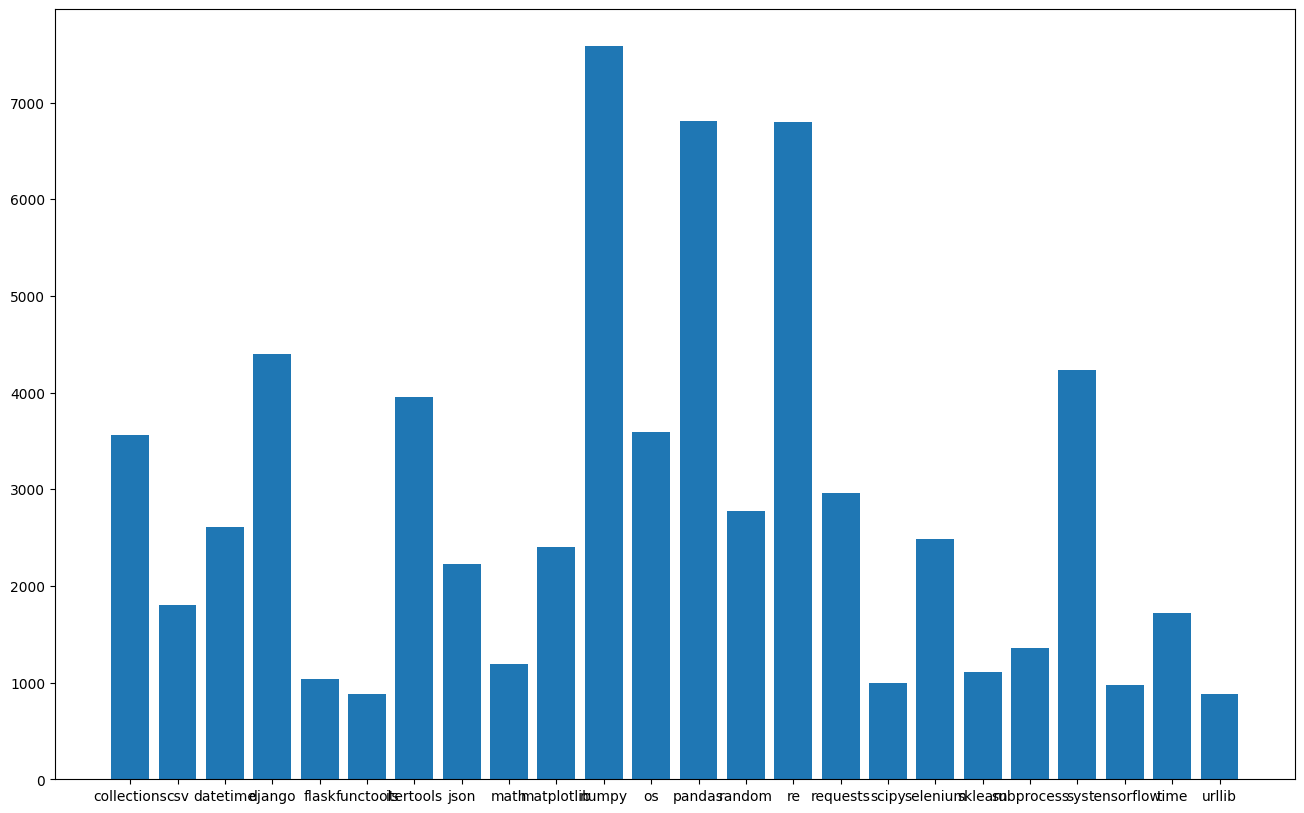

In [ ]:
libs, counts = np.unique(train_data["lib"].tolist(), return_counts=True)
plt.figure(figsize=(16, 10))
plt.bar(libs, counts)

## 0. Предобработка данных

In [ ]:
data_x, data_y = np.array(train_data.loc[:, "title"]), np.array(train_data.loc[:, "lib"])

In [ ]:
labels = np.unique(data_y)
label_to_idx = {label: i for i, label in enumerate(labels)}
n_classes = len(labels)
labels, n_classes

(array(['collections', 'csv', 'datetime', 'django', 'flask', 'functools',
        'itertools', 'json', 'math', 'matplotlib', 'numpy', 'os', 'pandas',
        'random', 're', 'requests', 'scipy', 'selenium', 'sklearn',
        'subprocess', 'sys', 'tensorflow', 'time', 'urllib'], dtype=object),
 24)

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from nltk.stem import PorterStemmer

from dataclasses import dataclass

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess(titles_x, labels_y):
    X, y = [], []
    stemmer = PorterStemmer()
    stopWords = set(stopwords.words('english')) | set(["'", "\"", ",", ".", "?", "!"])
    for title, label in tqdm(zip(titles_x, labels_y), total=len(titles_x)):
        tokens = wordpunct_tokenize(title.lower())
        tokens = list(map(stemmer.stem, tokens))
        proc_title = " ".join([token for token in tokens if token not in stopWords]).replace("&", "and")
        X.append(proc_title)
        y.append(label_to_idx[label])
    return np.array(X), np.array(y)

In [ ]:
data_x, data_y = preprocess(data_x, data_y)

  0%|          | 0/68369 [00:00<?, ?it/s]

In [ ]:
list(zip(data_x[:5], data_y[:5]))

[('way sort string alphabet order capit letter first', 5),
 ('maintain histori soft delet row tabl', 3),
 ('wave string analysi', 10),
 ('regular express find word part larger phrase', 14),
 ('textblob - loop articl calcul polar and subject score', 12)]

Для данной задачи пунктуация не важна, ровно как и эмоциональная окраска (которая может выражаться через "?" и "!")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y)
X_train.shape, y_train.shape

((51276,), (51276,))

## 1. Бейзлайн
Пусть это будет простая логистическая регрессия с *tf-idf* фичами

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import log_loss, accuracy_score, top_k_accuracy_score

In [ ]:
pipeline = Pipeline(
    [('vectorize', CountVectorizer()), ('transform', TfidfTransformer()), ('logregression', LogisticRegression(max_iter=1000))]
)

param_grid = {
    "logregression__C": [0.01, 0.025, 0.05, 0.1, 1, 10],
}

search_cv = GridSearchCV(pipeline, param_grid, verbose=3)
search_cv.fit(X_train, y_train)

In [ ]:
best_pipeline = search_cv.best_estimator_
y_pred = best_pipeline.predict(X_val)
y_pred_probas = best_pipeline.predict_proba(X_val)
y_pred[:5]

array([ 0, 20,  9,  3, 12])

In [ ]:
search_cv.best_params_

{'vectorize__max_df': 0.5, 'vectorize__min_df': 0}

In [ ]:
log_loss(y_val, y_pred_probas)

1.4457960611865246

In [ ]:
accuracy_score(y_val, y_pred)

0.601825308605862

In [ ]:
top_k_accuracy_score(y_val, y_pred_probas, k=3)

0.816884104604224

## 2. Сделаем датасет и даталоадер

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class CustomTagDataset(Dataset):
    def __init__(self, sentences, target):
        self._data = sentences
        self._target = target

    def __getitem__(self, idx: int):
        return ([self._data[idx]], torch.tensor([self._target[idx]], dtype=torch.int64))
    
    def __len__(self):
        return len(self._data)

In [ ]:
data_train = DataLoader(CustomTagDataset(X_train, y_train), batch_size=32, shuffle=True)
data_val = DataLoader(CustomTagDataset(X_val, y_val), batch_size=32, shuffle=True)

## Роберта!

In [ ]:
!pip install transformers
from transformers import AutoModel, AutoTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
roberta_model = AutoModel.from_pretrained('roberta-base')
# texts = [
#     "1 2 3 4 5",
#     "24 12 3"
#     ]
# encoded_input = roberta_tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=25)
# output = roberta_model(**encoded_input)
# output[0].shape

OSError: ignored

In [ ]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class RobertaTransformer:
    def __init__(self, tokenizer, model, device, *, embed_size=25):
        self.tokenizer = tokenizer
        self.model = model.to(device)
        self.embed_size = embed_size

    def transform_input(self, X):
        # return features fo shape (batch_size, self.embed_size, 768), 768 seems to be a constant
        tokenized_input = self.tokenizer(X, return_tensors='pt', padding=True, truncation=True, max_length=self.embed_size).to(device)
        out_features = self.model(**tokenized_input)[0]
        sh = out_features.shape
        return torch.concat([out_features, torch.zeros(sh[0], self.embed_size - sh[1], sh[2]).to(device)], dim=1)


class RobertaClassifier(nn.Module):
    def __init__(self, *, embed_size=25):
        super().__init__()
        self.embed_size = embed_size
        self.conv_layers =nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(),
            nn.BatchNorm2d(3),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(768 * self.embed_size * 3, 1000),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 200),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 24)
        )

    def forward(self, X):
        x = X[:, None, :, :]
        x = self.conv_layers(x)
        x = x.flatten(1, 3)
        x = self.linear_layers(x)
        return x  # self.softmax(x)


class MediumRobertaClassifier(nn.Module):
    def __init__(self, *, embed_size=25):
        super().__init__()
        self.embed_size = embed_size
        self.conv_layers =nn.Sequential(
            nn.Conv1d(1, 5, kernel_size=3, padding=1),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(5),
            nn.Conv1d(5, 5, kernel_size=3, padding=1),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(5),
            nn.Conv1d(5, 1, kernel_size=3, padding=1),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(1),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(768 * self.embed_size, 1000),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 24)
        )

    def forward(self, X):
        x = X.flatten(1, 2)[:, None, :]
        x = self.conv_layers(x)
        x = x.flatten(1, 2)
        x = self.linear_layers(x)
        return x


class SimpleRobertaClassifier(nn.Module):
    def __init__(self, *, embed_size=25):
        super().__init__()
        self.embed_size = embed_size
        self.linear1 = nn.Linear(768 * self.embed_size, 1000)
        self.drop = nn.Dropout()
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(1000, 24)
        self.bn = nn.BatchNorm1d(1000)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        x = X.flatten(1, 2)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear2(x)
        return x

In [ ]:
def train(model, transformer, train_data, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for X, y in tqdm(train_data, desc="Training", leave=False):
        x = transformer.transform_input(list(X[0]))
        x = x.to(device)
        optimizer.zero_grad()

        y_pred = model(x).to('cpu')
        loss = criterion(y_pred, y.flatten())
        loss.backward()
        optimizer.step()
        # print(roberta_classifier.state_dict()['conv_layers.0.weight'])

        epoch_loss += loss.item()

    return epoch_loss / len(train_data)


def evaluate(model, transformer, val_data, criterion, device):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for X, y in tqdm(val_data, desc="Evaluating", leave=False):
            x = transformer.transform_input(list(X[0]))
            x = x.to(device)
            y_pred = model(x).to('cpu')
            loss = criterion(y_pred, y.flatten())
            epoch_loss += loss.item()

    return epoch_loss / len(val_data)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
embed_size = 25
device = 'cuda' if torch.cuda.is_available() else 'cpu'
roberta_transformer = RobertaTransformer(roberta_tokenizer, roberta_model, device, embed_size=embed_size)
roberta_classifier = MediumRobertaClassifier(embed_size=embed_size).to(device)

optimizer = optim.Adam(params=roberta_classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device

'cuda'

In [ ]:
best_valid_loss = float('inf')
train_loss_storage, valid_loss_storage = [], []

EPOCHS = 25
for epoch in range(EPOCHS):
    start_time = time.monotonic()

    # print(roberta_classifier.state_dict()['conv_layers.0.weight'])

    train_loss = train(roberta_classifier, roberta_transformer, data_train, optimizer, criterion, device)
    train_loss_storage.append(train_loss)

    valid_loss = evaluate(roberta_classifier, roberta_transformer, data_val, criterion, device)
    valid_loss_storage.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(roberta_classifier.state_dict(), '/content/medium_roberta_best_config.pt')

    exp_lr_scheduler.step()
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 3m 45s
	Train Loss: 2.202
	 Val. Loss: 2.044


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 3m 45s
	Train Loss: 1.954
	 Val. Loss: 2.499


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 3m 45s
	Train Loss: 1.873
	 Val. Loss: 2.720


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 3m 45s
	Train Loss: 1.805
	 Val. Loss: 3.495


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 3m 46s
	Train Loss: 1.756
	 Val. Loss: 3.615


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 3m 46s
	Train Loss: 1.654
	 Val. Loss: 4.142


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 3m 45s
	Train Loss: 1.605
	 Val. Loss: 6.055


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 3m 45s
	Train Loss: 1.574
	 Val. Loss: 8.267


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 3m 46s
	Train Loss: 1.549
	 Val. Loss: 5.509


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 3m 46s
	Train Loss: 1.529
	 Val. Loss: 15.277


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 3m 46s
	Train Loss: 1.496
	 Val. Loss: 7.628


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 3m 46s
	Train Loss: 1.497
	 Val. Loss: 12.246


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 3m 45s
	Train Loss: 1.494
	 Val. Loss: 11.268


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 3m 44s
	Train Loss: 1.488
	 Val. Loss: 13.622


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 3m 46s
	Train Loss: 1.491
	 Val. Loss: 6.366


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 3m 45s
	Train Loss: 1.480
	 Val. Loss: 7.336


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 3m 45s
	Train Loss: 1.484
	 Val. Loss: 14.190


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 3m 45s
	Train Loss: 1.481
	 Val. Loss: 6.627


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 3m 46s
	Train Loss: 1.484
	 Val. Loss: 8.941


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 3m 46s
	Train Loss: 1.481
	 Val. Loss: 9.869


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 3m 45s
	Train Loss: 1.486
	 Val. Loss: 7.844


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 3m 45s
	Train Loss: 1.479
	 Val. Loss: 7.453


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 3m 46s
	Train Loss: 1.480
	 Val. Loss: 6.189


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 3m 45s
	Train Loss: 1.482
	 Val. Loss: 10.963


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 3m 45s
	Train Loss: 1.484
	 Val. Loss: 12.313


In [ ]:
model = MediumRobertaClassifier(embed_size=embed_size)
model.load_state_dict(torch.load('/content/medium_roberta_best_config.pt'))
model.to(device)
model.eval()

MediumRobertaClassifier(
  (conv_layers): Sequential(
    (0): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(5, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv1d(5, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): Dropout(p=0.3, inplace=False)
    (10): ReLU()
    (11): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=19200, out_features=1000, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1000, out_features=24, bias=True)
  )
)

In [ ]:
def predict(model, transformer, val_data, device, logits=False):
    epoch_loss = 0
    res = torch.tensor([], dtype=torch.float32)
    labels = torch.tensor([])
    softmax = nn.Softmax()

    with torch.no_grad():
        for X, y in tqdm(val_data, desc="Evaluating", leave=False):
            x = transformer.transform_input(list(X[0]))
            x = x.to(device)
            y_pred = model(x).to('cpu')
            res = torch.concat([res, y_pred if logits else softmax(y_pred)], dim=0)
            labels = torch.concat([labels, y])

    return res, labels

In [ ]:
predicted_probs, gt1 = predict(model, roberta_transformer, data_val, device)
predicted_logits, gt2 = predict(model, roberta_transformer, data_val, device, logits=True)

Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

<ipython-input-116-99882860c2f5>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = torch.concat([res, y_pred if logits else softmax(y_pred)], dim=0)


Evaluating:   0%|          | 0/535 [00:00<?, ?it/s]

In [ ]:
predicted_probs[0]

tensor([0.0217, 0.0143, 0.0281, 0.0041, 0.0020, 0.0223, 0.0272, 0.0374, 0.0459,
        0.0278, 0.2733, 0.0142, 0.0411, 0.0308, 0.0710, 0.0034, 0.0485, 0.0008,
        0.0975, 0.0059, 0.0738, 0.0882, 0.0187, 0.0021])

In [ ]:
top_k_accuracy_score(gt1, predicted_probs, k=1)

0.4577897384894401

In [ ]:
log_loss(gt2, predicted_logits)

6.033579112573591